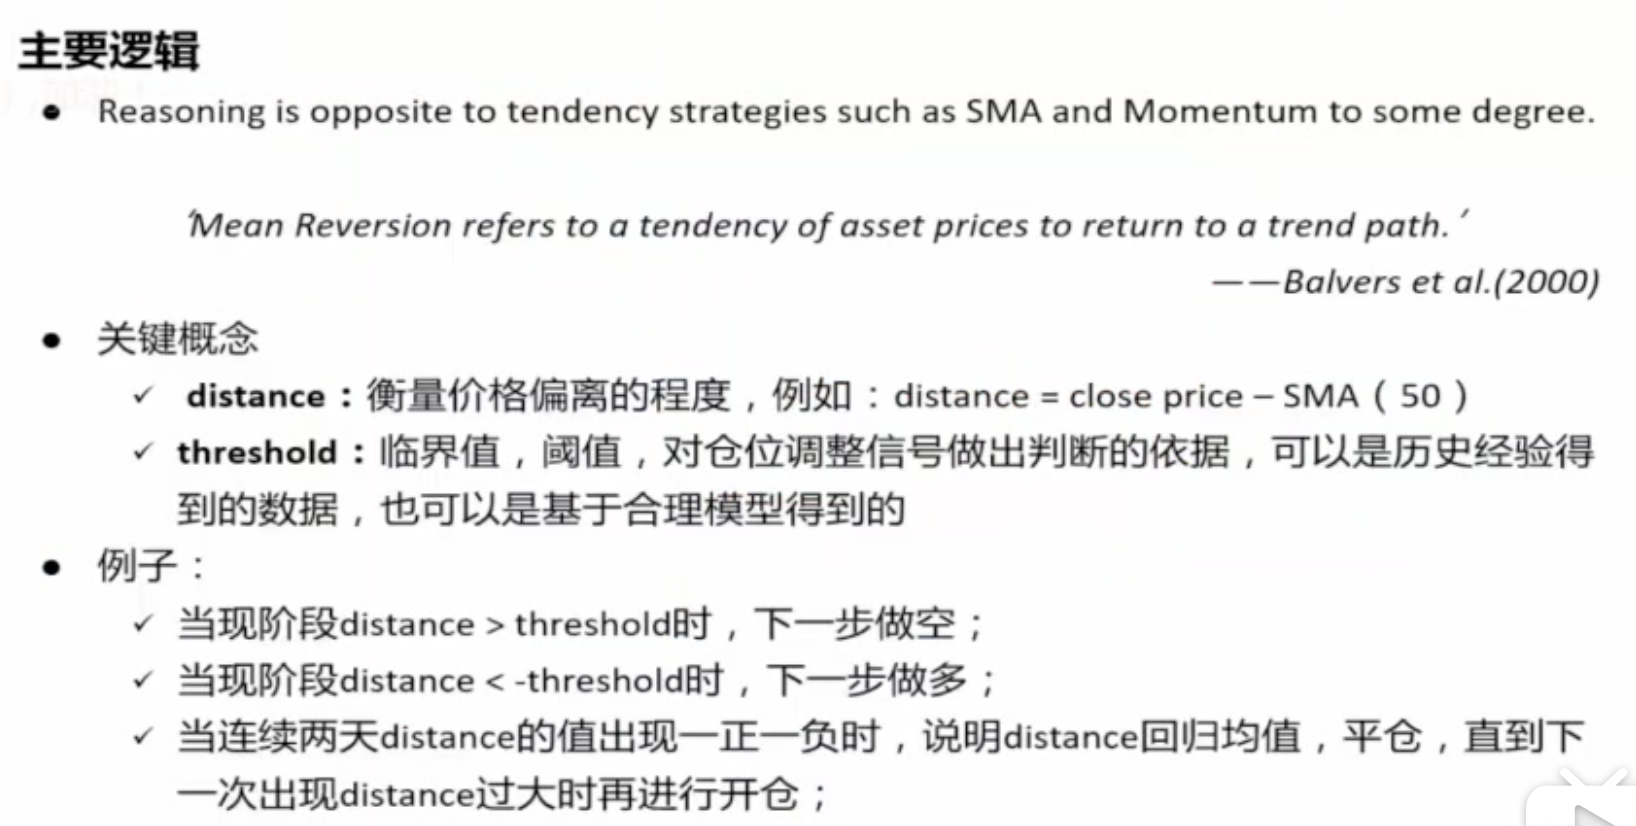

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')

In [5]:
import numpy as np
import pandas as pd
import tushare as ts

### 策略思想

均值回归一般在震荡市时表现较好，再单边趋势行情时表现糟糕

### 1.数据准备&回测准备

In [8]:
data = ts.get_k_data('hs300',start='2010-01-01',end='2014-06-30')[['date','close']]
data.rename(columns={'close':'price'},inplace=True)
data.set_index('date',inplace=True)
data.head()

,price
date,
2010-01-04,3535.229
2010-01-05,3564.038
2010-01-06,3541.727
2010-01-07,3471.456
2010-01-08,3480.130


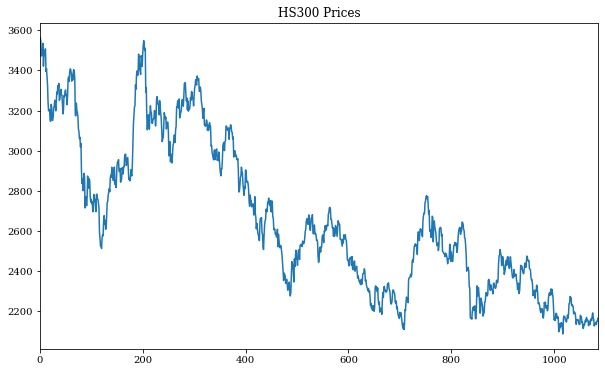

In [7]:
data['price'].plot(title='HS300 Prices',figsize=(10,6))

### 2.策略开发思路

In [23]:
SMA = 50
data['SMA'] = data['price'].rolling(SMA).mean()
threshold = 250 #由于hs300是指数，所以阈值比较大
data['distance'] = data['price']-data['SMA']
data.tail()

,price,SMA,distance
date,,,
2014-06-24,2144.82,2164.4240,-19.6040
2014-06-25,2133.37,2161.6780,-28.3080
2014-06-26,2149.08,2159.2874,-10.2074
2014-06-27,2150.26,2157.7034,-7.4434
2014-06-30,2165.12,2156.3552,8.7648


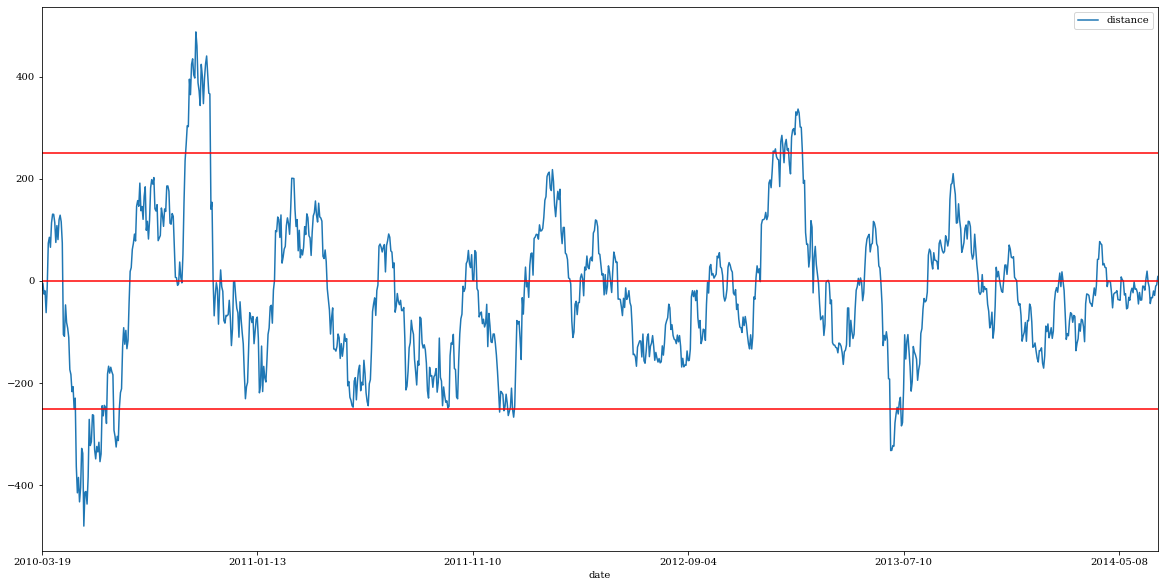

In [52]:
data['distance'].dropna().plot(figsize=(20,10),legend=True)
plt.axhline(threshold,color='r')  #添加阈值线
plt.axhline(-threshold,color='r') #添加阈值线
plt.axhline(0,color='r')

In [45]:
data['position'] = np.where(data['distance']>threshold,-1,np.nan) #开仓-short
data['position'] = np.where(data['distance']<-threshold,1,data['position']) #开仓-long
data['position'] = data['position'].ffill().fillna(0) #向前填充：即对于所有没有指令的空值，保留上一时刻的仓位
data['position'] = np.where(data['distance'] * data['distance'].shift(1)<0,
                            0,data['position'])
# 平仓：将所有long，short之间的转化的仓位记为0
data.tail(100)

,price,SMA,distance,position,returns,strategy
date,,,,,,
2014-01-29,2227.78,2319.2688,-91.4888,1.0,0.003566,0.0
2014-01-30,2202.45,2314.8208,-112.3708,1.0,-0.011435,-0.0
2014-02-07,2212.48,2310.8706,-98.3906,1.0,0.004544,0.0
2014-02-10,2267.53,2308.2620,-40.7320,1.0,0.024577,0.0
2014-02-11,2285.56,2306.2006,-20.6406,1.0,0.007920,0.0
...,...,...,...,...,...,...
2014-06-24,2144.82,2164.4240,-19.6040,1.0,0.005006,0.0
2014-06-25,2133.37,2161.6780,-28.3080,1.0,-0.005353,-0.0
2014-06-26,2149.08,2159.2874,-10.2074,1.0,0.007337,0.0


In [46]:
data['returns'] = np.log(data['price']/data['price'].shift(1))
data['strategy'] = data['position'].shift(1) * data['returns']
data.tail()

,price,SMA,distance,position,returns,strategy
date,,,,,,
2014-06-24,2144.82,2164.4240,-19.6040,1.0,0.005006,0.005006
2014-06-25,2133.37,2161.6780,-28.3080,1.0,-0.005353,-0.005353
2014-06-26,2149.08,2159.2874,-10.2074,1.0,0.007337,0.007337
2014-06-27,2150.26,2157.7034,-7.4434,1.0,0.000549,0.000549
2014-06-30,2165.12,2156.3552,8.7648,0.0,0.006887,0.006887


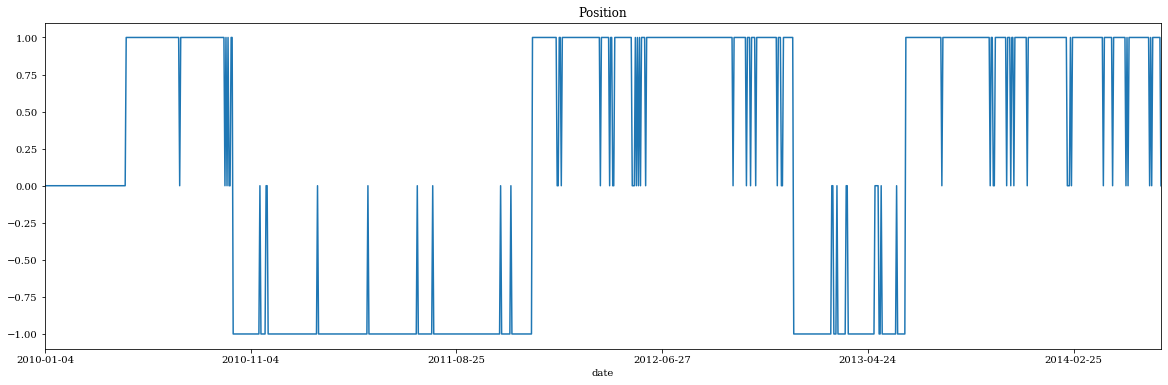

In [47]:
data['position'].plot(ylim=(-1.1,1.1),title='Position',figsize=(20,6))

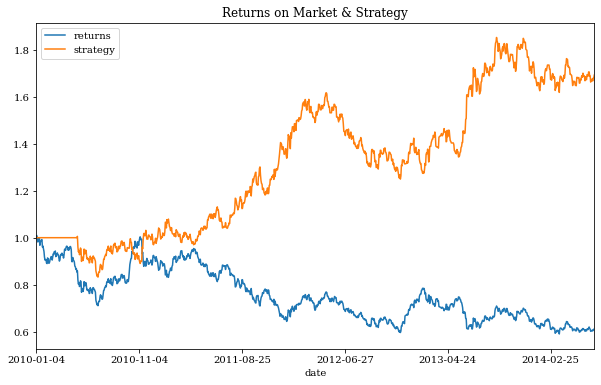

In [48]:
data[['returns','strategy']].cumsum().apply(np.exp).plot(title='Returns on Market & Strategy',figsize=(10,6))

### 3 计算年华收益率

In [50]:
data['strategy'].mean() *252

0.12212184768055934

In [51]:
data['strategy'].std() *252**0.5

0.20106111830515194